Before running this notebook - install this package
(i.e., in the terminal, inside this folder run:
"pip install -e .")
Also make sure that prfpy is installed
& that you are running the correct kernel

If you have your own data, I would reccomend loading in 100 voxels first. Visually inspect them to check for the kind of bumps that display visual responses. Then run the analysis to check that everything is working.
For full brain data, you will probably want to run on a cluster if it is available. But it is also doable locally.  

In [24]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter
from prfpy.rf import gauss2D_iso_cart
import os
import yaml
import pickle
from datetime import datetime

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.prfpy_ts_plotter import *
from dag_prf_utils.fs_tools import * # Load in my tools to plot things on the freesurfer surface

from hemi_prf.utils import *
from hemi_prf.plot_functions import *
from hemi_prf.load_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# First we need to load the settings
sub = 'sub-01'
fit_settings = hprf_load_fit_settings(sub=sub) # from the yaml file
prf_stim = hprf_load_prfpy_stim()
gauss_model = Iso2DGaussianModel(
    stimulus=prf_stim,                                  # The stimulus we made earlier
    hrf = fit_settings['hrf']['pars'],
    )
ts_plot = {}
for dt in [0,5]:
    ts_psc = hprf_load_ts_psc(sub=sub, detrend=dt)
    prf_params  = hprf_load_fit_prfs(sub=sub, detrend=dt)
    ts_plot[dt] = TSPlotter(
        prf_params=prf_params,
        real_ts=ts_psc,
        model='gauss',
        prfpy_model=gauss_model,
        
    )

prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=8
include hrf = True
include rsq = True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


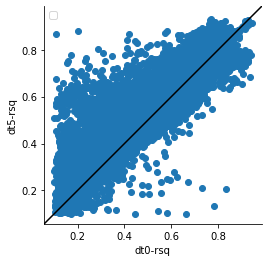

In [28]:
prf_multi = PrfMulti([ts_plot[0], ts_plot[5]], ['dt0', 'dt5'])
prf_multi.scatter(
    px='dt0-rsq', py='dt5-rsq', do_id_line=True,
)

In [29]:
surf_maker = FSMaker(
    sub='sub-01',
    fs_dir='/data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer',
)
for dt in [0, 5]:
    vx_mask = ts_plot[dt].return_vx_mask({
        'min-rsq':.1,
        'max-ecc' : 5,
        })

    surf_maker.add_surface(
        surf_name=f'ecc-dt{dt}', 
        data=ts_plot[dt].pd_params['ecc'].to_numpy(),
        data_mask = vx_mask,
        vmin=0, vmax=5, cmap='ecc2'
    )

    surf_maker.add_surface(
        surf_name=f'pol-dt{dt}', 
        data=ts_plot[dt].pd_params['pol'].to_numpy(),
        data_mask = vx_mask,
        vmin=-np.pi, vmax=np.pi, cmap='marco_pol'
    )  
surf_maker.open_fs_surface(surf_maker.surf_list)

Saving ecc-dt0 in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom
Saving pol-dt0 in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom
Saving ecc-dt5 in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom
Saving pol-dt5 in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom
freeview -f  lh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom/lh.ecc-dt0:overlay_custom=0.00,0,0,128,0.26,0,0,173,0.53,0,0,218,0.79,0,25,255,1.05,0,116,255,1.32,0,214,255,1.58,0,255,204,1.84,0,255,106,2.11,0,255,15,2.37,0,214,0,2.63,0,168,0,2.89,8,128,0,3.16,53,128,0,3.42,102,128,0,3.68,148,107,0,3.95,197,58,0,4.21,242,12,0,4.47,218,0,0,4.74,173,0,0,5.00,128,0,0,:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/p

QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1407, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1656, resource id: 65011816, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1656, resource id: 65011816, major code: 54 (FreePixmap), minor code: 0
internal error:  void QXcbWindow::setNetWmStateOnUnmappedWindow() called on mapped window
internal error:  void QXcbWindow::setNetWmStateOnUnmappedWindow() called on mapped window
e: 54 (FreePixmap), minor code: 0


RAS: -13.8117 -67.9571 -6.0370
SurfaceRAS: -14.8117 -73.0249 -20.9985
SurfaceRAS: -14.8117 -73.0249 -20.9985


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


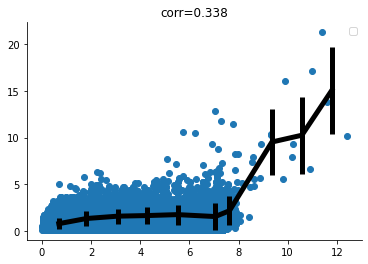

In [11]:
ts_plot.scatter(
    px='ecc', py='size_1', do_corr=True, do_line=True,
)

In [25]:
# SUBJECT CORRELATION
ts_corr_dt0 = hprf_load_run_correlation('sub-01', detrend=0) # Load run correlation for this subject
ts_corr_dt5 = hprf_load_run_correlation('sub-01', detrend=5) # Load run correlation for this subject
surf_maker = FSMaker(
    sub='sub-01',
    fs_dir='/data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer',
)

surf_maker.add_surface(
    surf_name='run_correlation_dt0',
    data=ts_corr_dt0,
    cmap='RdBu_r', vmin=-1, vmax=1,  # colormap blue - negative correlation
)

surf_maker.add_surface(
    surf_name='run_correlation_dt5',
    data=ts_corr_dt5,
    cmap='RdBu_r', vmin=-1, vmax=1,  # colormap blue - negative correlation
)
# vx_mask = ts_plot.return_vx_mask({
#     'min-rsq':.1,
#     'max-ecc' : 5,
#     })

# surf_maker.add_surface(
#     surf_name='ecc', 
#     data=ts_plot.pd_params['ecc'].to_numpy(),
#     data_mask = vx_mask,
#     vmin=0, vmax=5, cmap='ecc2'
# )

# surf_maker.add_surface(
#     surf_name='pol', 
#     data=ts_plot.pd_params['pol'].to_numpy(),
#     data_mask = vx_mask,
#     vmin=-np.pi, vmax=np.pi, cmap='marco_pol'
# )
surf_maker.open_fs_surface(surf_maker.surf_list)

Saving run_correlation_dt0 in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom
Saving run_correlation_dt5 in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom
freeview -f  lh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom/lh.run_correlation_dt0:overlay_custom=-1.00,5,48,97,-0.89,19,75,135,-0.79,33,102,172,-0.68,52,127,185,-0.58,73,150,197,-0.47,116,178,211,-0.37,154,201,224,-0.26,189,218,234,-0.16,216,232,241,-0.05,237,242,245,0.05,248,239,234,0.16,251,224,208,0.26,250,202,177,0.37,245,172,139,0.47,232,139,110,0.58,216,101,81,0.68,198,64,62,0.79,178,25,43,0.89,141,12,37,1.00,103,0,31,:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/hemi_prf/derivatives/freesurfer/sub-01/surf/custom/lh.run_correlation_dt5:overlay_custom=-1.00,5,48,97,-0.89,19,75,135,-0.79,33,102,172,-0.68,52,127,185

QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1457, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1457, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1920, resource id: 58720365, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1920, resource id: 58720365, major code: 54 (FreePixmap), minor code: 0


RAS: -8.7616 -63.4077 -9.2178
SurfaceRAS: -9.7616 -68.4755 -24.1794
SurfaceRAS: -9.7616 -68.4755 -24.1794
RAS: 18.1544 -69.7802 -8.4001
SurfaceRAS: 17.1544 -74.8480 -23.3617
SurfaceRAS: 17.1544 -74.8480 -23.3617
RAS: -32.1070 -70.7519 22.8857
SurfaceRAS: -33.1070 -75.8197 7.9242
SurfaceRAS: -33.1070 -75.8197 7.9242



In [17]:
np.where(ts_plot.pd_params['rsq']>0.5)

(array([    42,    134,    137, ..., 260408, 260688, 260707]),)

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:112: RuntimeWarning: divide by zero encountered in true_divide
  return (np.exp(-((x-mu[0])**2 + (y-mu[1])**2)/(2*sigma**2))).astype('float32')


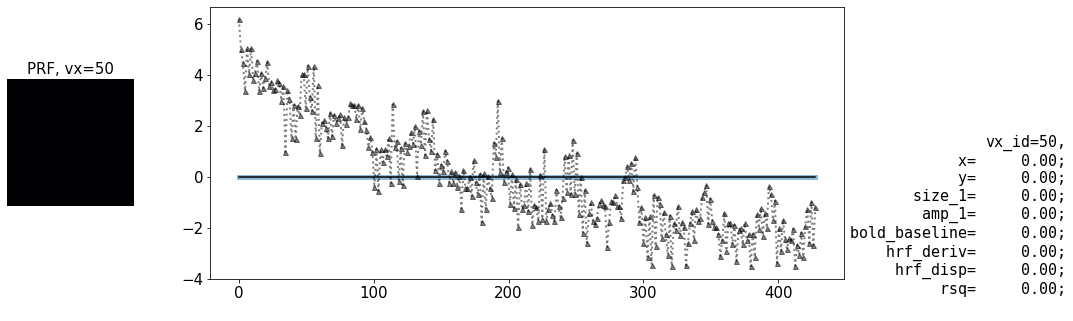

In [23]:
ts_plot.prf_ts_plot(50)

# Preparing the data
The next step is to prepare the fMRI time series. The format that prfpy wants is a numpy array of number of 
For prfpy the time series needs to be 2D numpy array, where the first dimension is units (i.e., voxels or vertices) and the second dimension is time. The number of timepoints in your data should match the number in the design matrix (here it is 225). 

A couple of notes:

[*] Preprocessing? I assume that all of the important stuff, i.e., denoising, removing confounds has been done already. This is just to prepare the data for prfpy specifically. 

[*] Averaging? The more runs (i.e., repetitions of the same stimulus) you average over, the less noise, and the better the prf estimates will be. You can fit on a single run (especially in high SNR situations, e.g., using 7T) without averaging, but quality will be less good. 

[*] Voxels or vertices? In principle you can fit any time series data with a prf model. I always fit using vertices, with the data sampled to the cortical surface. This will make visualisations much easier, if you want to plot your PRF parameters on the cortical surface. You can then use tools like pycortex

[*] Percent signal change? Again, in principle you can fit any time series data with a prf model. I use percent signal change, with the baseline set to 0. Why do this? It makes it easier to compare timeseries across voxels when the units are the same (as opposed to the arbitrary values you get out of "raw" fMRI data). Also, if you do *not* set the baseline value to 0 (i.e. the amplitude of the prf model when there is 0 stimulation) you need to fit it for each vertex. There are also added complications when you have PRFs with inhibitory components. Another option is to use z-scoring rather than psc. 

[*] Include first part of timeseries? Some people will remove the first (e.g.,5) timepoints of the fMRI data. This is because perhaps it takes a couple of seconds for the subject to get used to the scanner / stimulus or maybe there are startup effects... If you want to do this, make sure you make the corresponding changes to the design matrix.  

### Steps, using example data
I have provided some example time series data for 100 vertices

[1] Convert to percent signal change

[2] Set the median value during the baseline condition (i.e., when there is no stimulation) to zero

See functions in marcus_prf_eg/utils for more details


In [54]:
# Load preprocessed time series (psc), only look at first 100
psc_avg_ts = hprf_load_ts_psc('sub-01', 'ses-1')
psc_avg_ts  = psc_avg_ts[:100,:]

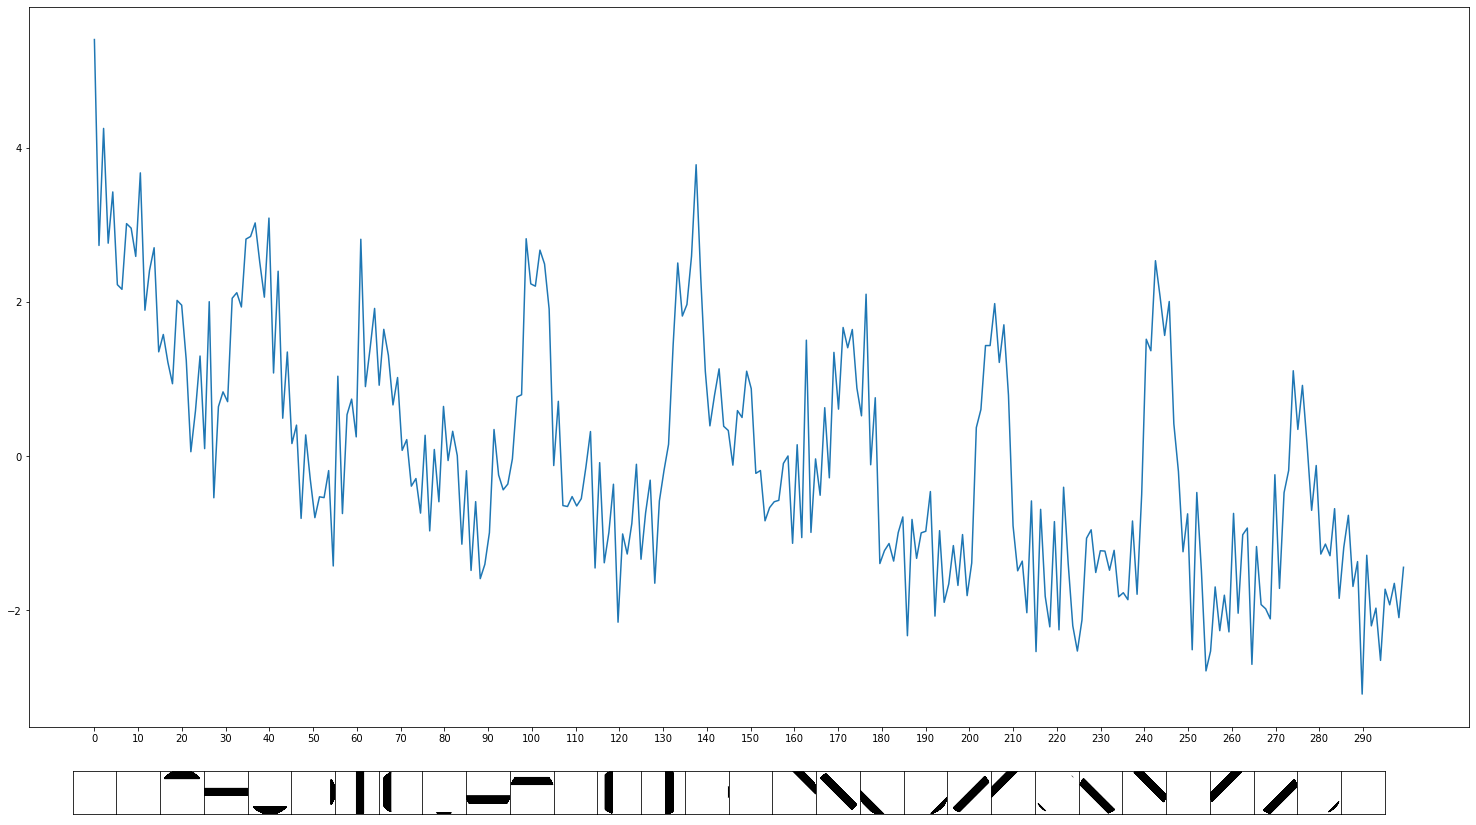

In [62]:
TR_s = prf_info['TR']
time_pts = np.arange(psc_avg_ts.shape[1]) * TR_s
i_vx = 0

fig = plt.figure()
fig.set_size_inches(20,10)
ax = fig.add_axes([0,0,1,1])
ax.plot(time_pts, psc_avg_ts[-1,:])
ax.set_xticks(np.arange(time_pts[0], time_pts[-1],10))
add_dm_to_ts(fig, ax, dm, TR=TR_s, dx_axs=2)

Example, raw time series. You can already see the peaks corresponding to the bar passes. 
But the units are arbitrary... We want to change it to be in psc
Also we can improve the SNR by averaging over the 2 runs...

# Creating the (gaussian) model
Now we can create the PRF model. The simplest is the 2D isometric (i.e., circular) gaussian


The Iso2DGaussianModel class is used to create an 2D gaussian model instance.
There are a few parameters you can set. See below (copied from prfpy documentation), for details.
Note you can also fit the HRF

In [63]:
'''    
    """__init__ for Iso2DGaussianModel
    constructor, sets up stimulus and hrf for this Model
    Parameters
    ----------
    stimulus : PRFStimulus2D
        Stimulus object specifying the information about the stimulus,
        and the space in which it lives.
    hrf : string, list or numpy.ndarray, optional
        HRF shape for this Model.
        Can be 'direct', which implements nothing (for eCoG or later convolution),
        a list or array of 3, which are multiplied with the three spm HRF basis functions,
        and an array already sampled on the TR by the user.
        (the default is None, which implements standard spm HRF)
    filter_predictions : boolean, optional
        whether to high-pass filter the predictions, default False
    filter_type, filter_params : see timecourse.py
    normalize_RFs : whether or not to normalize the RF volumes (generally not needed).
'''
gg = Iso2DGaussianModel(
    stimulus=prf_stim,                                  # The stimulus we made earlier
    hrf=prf_info['hrf']['pars'],                        # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
    filter_predictions = prf_info['filter_predictions'],# Do you want to filter the predictions? (depends what you did to the data, try and match it... default is not to do anything)
    normalize_RFs= prf_info['normalize_RFs'],           # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
    )

A note on the HRF

Generally we only to fit "hrf_1" (i.e., the derivative). The HRF is created using the 3 SPM basis functions, and the 3 hrf parameters determine how this works. We tend to fix hrf_pars[0] to = 1, as parameter can confound with the size and the amplitude of the PRF estimate. Similarly we generally fix hrf_2 (the dispersion) to =0, because it can confound with inhibitory PRF models. It is possible to fix all the HRF parameters (i.e., and use the default) and still get good quality PRF fits.   


# Creating the gaussian fitter
Now we need to make a fitter, to load in the data


In [34]:
gf = Iso2DGaussianFitter(
    data=psc_avg_ts,            # time series
    model=gg,                   # model (see above)
    n_jobs=prf_info['n_jobs'],  # number of jobs to use in parallelization 
    )

## Gaussian grid fit
The first stage is the 'grid fit'
Here we make a "grid" of possible PRF models, (different locations: polar angle, eccentricity, as well as sizes)

In [64]:
max_eccentricity = prf_stim.screen_size_degrees/2 # It doesn't make sense to look for PRFs which are outside the stimulated region
grid_nr = prf_info['grid_nr'] # Size of the grid (i.e., number of possible PRF models). Higher number means that the grid fit will be more exact, but take longer...
eccs    = max_eccentricity * np.linspace(0.25, 1, grid_nr)**2 # Squared because of cortical magnification, more efficiently tiles the visual field...
sizes   = max_eccentricity * np.linspace(0.1, 1, grid_nr)**2  # Possible size values (i.e., sigma in gaussian model) 
polars  = np.linspace(0, 2*np.pi, grid_nr)              # Possible polar angle coordinates

# We can also fit the hrf in the same way (specifically the derivative)
# -> make a grid between 0-10 (see settings file)
hrf_1_grid = np.linspace(prf_info['hrf']['deriv_bound'][0], prf_info['hrf']['deriv_bound'][1], 5)
# We generally recommend to fix the dispersion value to 0
hrf_2_grid = np.array([0.0])

# If you don't want to do any hrf fitting - set both to be NONE (uncomment below)
hrf_1_grid = None
hrf_2_grid = None


# *** Save your fitting parameters:
# We may run our analysis several times. If so we want to save the important information all together
# We will use a pickle file to do this.
prf_info['max_eccentricity']  = max_eccentricity
prf_info['eccs'] = eccs
prf_info['sizes'] = sizes
prf_info['polars'] = polars
prf_info['hrf_1_grid'] = hrf_1_grid
prf_info['hrf_2_grid'] = hrf_2_grid

We also want to put some boundaries on possible values
We set the baseline to 0, so we want to fix that here. 'fixed_grid_baseline=0'
In addition, there is the amplitude parameter (which scales the response). 
We want to put an upper limit for this too, so that we don't get strange responses

In [65]:
# Amplitude bounds for gauss grid fit - set [min, max]
gauss_grid_bounds = [[prf_info['prf_ampl'][0],prf_info['prf_ampl'][1]]] 


gf.grid_fit(
    ecc_grid=eccs,
    polar_grid=polars,
    size_grid=sizes,
    hrf_1_grid=hrf_1_grid,
    hrf_2_grid=hrf_2_grid,
    verbose=True,
    n_batches=prf_info['n_batches'],               # The grid fit is performed in parallel over n_batches of units.Batch parallelization is faster than single-unit parallelization and of sequential computing.
    # fixed_grid_baseline=False, #prf_info['fixed_grid_baseline'], # Fix the baseline? This makes sense if we have fixed the baseline in preprocessing
    # grid_bounds=gauss_grid_bounds
    )
# Sometimes the fits are bad and will return NaN values. We do not want this so will remove them here:
# gf.gridsearch_params = filter_for_nans(gf.gridsearch_params)
# gf.gridsearch_r2 = filter_for_nans(gf.gridsearch_r2)

print(f'Mean rsq = {gf.gridsearch_r2.mean():.3f}')

prf_info['gauss_grid_bounds'] = gauss_grid_bounds

Each batch contains approx. 10 voxels.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Mean rsq = 0.157


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished


In [66]:
from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.prfpy_ts_plotter import *
ts = TSPlotter(
    prf_params=gf.gridsearch_params,
    model='gauss', 
    prfpy_model=gg,
    real_ts=psc_avg_ts,     
    TR_in_s = TR_s,
)

prf_params.shape[-1]=8
include hrf = True
include rsq = True


In [67]:
np.where(gf.gridsearch_r2>0.4)[0]

array([28, 36, 37, 42, 43, 77, 88, 89, 90])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


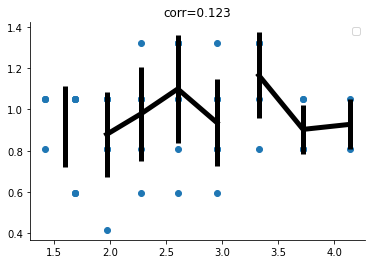

In [68]:
fig = plt.figure()
ax = plt.gca()
# ts.visual_field(ax=ax, dot_col='rsq')
ts.scatter(ax=ax, px='ecc', py='size_1', do_line=True, do_corr=True)

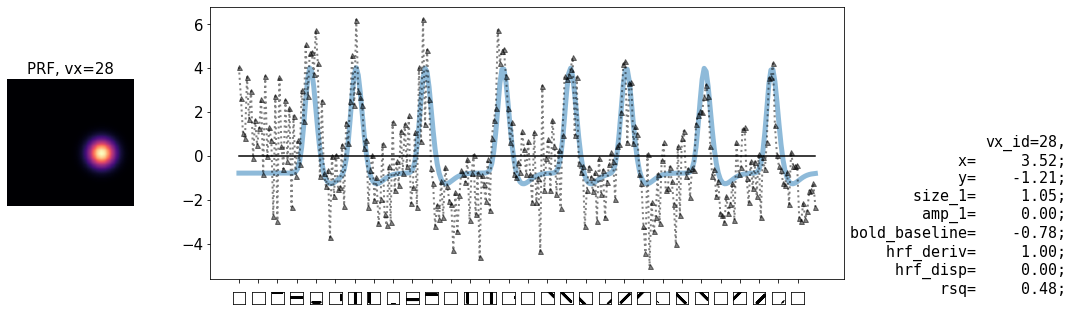

In [69]:
ts.prf_ts_plot(28)
ax = plt.gcf().get_children()[2]
# ax.set_xticks(np.arange(time_pts[0], time_pts[-1],10))
ax.set_xticks(np.arange(time_pts[0], time_pts[-1],10))
ax.set_xticklabels('')
add_dm_to_ts(plt.gcf(), ax, dm, TR=TR_s, dx_axs=2)

In [ ]:
# Save grids: 
if prf_info['save_grids']:
    print('saving grids')
    grid_file = './grid_fit.pkl'
    grid_dict = {}
    grid_dict['settings'] = prf_info # Save the settings into the pickle file
    grid_dict['pars'] = gf.gridsearch_params # Save the parameters into the pickle file
    grid_dict['date'] = datetime.now().strftime('%Y-%m-%d_%H-%M') # save the date into pickle
    f = open(grid_file, "wb")
    pickle.dump(grid_dict, f)
    f.close()



## Gaussian Iterative Fit
Now we can do the iterative fit. This takes the best fitting grid (from the above stage), and iteratively tweaks the parameters until the best fit is founds. 
This takes a bit longer than the grid fit. We also need to setup the bounds for all the parameters. 

In [43]:
gauss_bounds = [
    (-1.5*max_eccentricity, 1.5*max_eccentricity),          # x bound
    (-1.5*max_eccentricity, 1.5*max_eccentricity),          # y bound
    (1e-1, max_eccentricity*3),                             # prf size bounds
    (prf_info['prf_ampl'][0],prf_info['prf_ampl'][1]),      # prf amplitude
    (prf_info['bold_bsl'][0],prf_info['bold_bsl'][1]),      # bold baseline (fixed)
    (prf_info['hrf']['deriv_bound'][0], prf_info['hrf']['deriv_bound'][1]), # hrf_1 bound
    (prf_info['hrf']['disp_bound'][0], prf_info['hrf']['disp_bound'][1]), # hrf_2 bound
]
prf_info['gauss_bounds'] = gauss_bounds


In [70]:
if prf_info['constraints']:
    # TRUE -> use trust constraint fitter:
    g_constraints = [] # Empty value for constraints. It is possible to specify something here (e.g., that the PRF cannot be very small at high eccentricities...)
else:
    # FALSE -> use BGFS fitter (faster, but stays closer to the grid)
    g_constraints = None # uses l-BFGS (which is faster)


gf.iterative_fit(
    rsq_threshold=prf_info['rsq_threshold'],    # Minimum variance explained. Puts a lower bound on the quality of PRF fits. Any fits worse than this are thrown away...     
    verbose=True,
    bounds=gauss_bounds,       # Bounds (on parameters)
    constraints=g_constraints, # Constraints
    xtol=float(prf_info['xtol']),     # float, passed to fitting routine numerical tolerance on x
    ftol=float(prf_info['ftol']),     # float, passed to fitting routine numerical tolerance on function
    )               
# Xtol and Ftol determine when the fitter stops trying to improve the fit. Set to higher values to to terminate sooner and speed up the fitting
# Sometimes the fits are bad and will return NaN values. We do not want this so will remove them here:
# gf.iterative_search_params = filter_for_nans(gf.gridsearch_params)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nile

Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73360D+02    |proj g|=  9.00000D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16724D+02    |proj g|=  1.06550D+01
Performing bounded, unconstrained minimization (L-BFGS-B).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92122D+02    |proj g|=  9.00000D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  8.45922D+02    |proj g|=  4.21390D+00

At iterate    2    f=  8.45921D+02    |proj g|=  1.06456D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2      8      5     0     1   1.065D+01   8.459D+02
  F =   845.92144501377584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95596D+03    |proj g|=  9.00000D+00

At iterate


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47826D+03    |proj g|=  9.50874D+00

At iterate    2    f=  8.68965D+02    |proj g|=  9.99998D+02

At iterate    1    f=  1.11749D+03    |proj g|=  9.99999D+02

At iterate    3    f=  1.93795D+03    |proj g|=  9.61733D+00
  ys=-6.540E+00  -gs= 4.844E+00 BFGS update SKIPPED

At iterate    3    f=  8.68858D+02    |proj g|=  9.99998D+02

At iterate    2    f=  1.11725D+03    |proj g|=  2.45614D+00

At iterate    4    f=  1.93785D+03    |proj g|=  9.59921D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    2    f=  7.51733D+02    |proj g|=  9.99998D+02

At iterate    1    f=  1.09875D+03    |proj g|=  9.99999D+02

At iterate    3    f=  7.51608D+02    |proj g|=  7.54439D+00

At iterate    2    f=  9.24379D+02    |proj g|=  9.76482D+00

At iterate    4    f=  7.50641D+02    |proj g|=  8.78864D+00

At iterate    2    f=  1.09800D+03    |proj g|=  8.06393D+02

At iterate    5    f=  7.47013D+02    |proj g|=  9.99998D+02

At iterate    3    f=  9.24300D+02    |proj g|=  7.56153D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3     10      6     0     0   7.562D+02   9.243D+02
  F =   924.299864577


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  6.71100D+02    |proj g|=  9.99999D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66265D+03    |proj g|=  9.44705D+00

At iterate    1    f=  1.79318D+03    |proj g|=  9.99999D+02

At iterate    1    f=  5.96662D+02    |proj g|=  9.99999D+02

At iterate    2    f=  6.68001D+02    |proj g|=  5.40563D+00

At iterate    2    f=  1.79313D+03    |proj g|=  8.92123D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2      8      4     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  6.32378D+02    |proj g|=  9.09131D+00

At iterate    1    f=  6.29685D+02    |proj g|=  9.99998D+02

At iterate    6    f=  6.32372D+02    |proj g|=  9.08911D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     16     11     0     0   9.089D+00   6.324D+02
  F =   632.37213778810565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).

At iterate    2    f=  6.28942D+02    |proj g|=  8.97072D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    3    f=  8.34732D+02    |proj g|=  5.28760D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53676D+03    |proj g|=  1.01934D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.80079D+02    |proj g|=  9.00000D+00

At iterate    4    f=  8.34676D+02    |proj g|=  1.00000D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    2    f=  4.45204D+02    |proj g|=  9.99999D+02

At iterate    3    f=  4.44902D+02    |proj g|=  9.99999D+02


At iterate    1    f=  1.81809D+03    |proj g|=  1.04101D+01
At iterate    4    f=  4.44623D+02    |proj g|=  2.46177D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     17      4     0     3   1.041D+01   1.818D+03
  F =   1818.0856856568635     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).

At iterate    5    f=  4.44491D+02    |proj g|=  2.46177D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine p


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    6    f=  4.44392D+02    |proj g|=  8.51353D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14265D+03    |proj g|=  9.00000D+00

At iterate    1    f=  4.99250D+02    |proj g|=  7.12781D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     12      3     0     2   7.128D+00   4.992D+02
  F =   499.24970076658610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).
RUNNING THE


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    7    f=  4.44392D+02    |proj g|=  8.51352D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     17      9     0     0   8.514D+02   4.444D+02
  F =   444.39235662179829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17472D+02    |proj g|=  9.01930D+00

At iterate    1    f=  6.72920D+02    |proj g|=  5.11462D+00

          


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.5s

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.89466D+02    |proj g|=  6.66914D+00

At iterate    1    f=  1.14265D+03    |proj g|=  9.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     17      4     0     3   9.000D+00   1.143D+03
  F =   1142.6544814914687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).

At iterate    1    f=  5.17472D+02    |proj g|=  7.22777D+00

          


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  4.88757D+02    |proj g|=  9.99999D+02

At iterate    1    f=  4.72973D+02    |proj g|=  9.23252D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     14      5     0     4   9.233D+00   4.730D+02
  F =   472.97334943860932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).

At iterate    2    f=  4.87775D+02    |proj g|=  3.78968D+00

At iterate    1    f=  4.46411D+02    |proj g|=  9.99999D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30083D+02    |proj g|=  1.18629D+01

At iterate    3    f=  4.45925D+02    |proj g|=  9.99999D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3      9      7     0     0   1.000D+03   4.459D+02
  F =   445.92523801536993     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  3.30007D+02    |proj g|=  9.99999D+02

At iterate    2    f=  3.29992D+02    |proj g|=  9.99999D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2      8      5     0     0   1.000D+03   3.300D+02
  F =   329.99198775162790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Performing bounded, unconstrained minimization (L-BFGS-B).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.06463D+02    |proj g|=  1.06550D+01

At iterate


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  3.53905D+02    |proj g|=  4.38478D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     15      3     0     2   4.385D+00   3.539D+02
  F =   353.90533732074664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  4.09022D+02    |proj g|=  1.15104D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     17      4     0     3   1.151D+01   4.090D+02
  F =   409.02214785337901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    1    f=  5.06463D+02    |proj g|=  1.06550D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:   12.2s finished


# WELL DONE!
We now have a set of prf fits. 


(-7.103317512782181, 7.103317512782181)

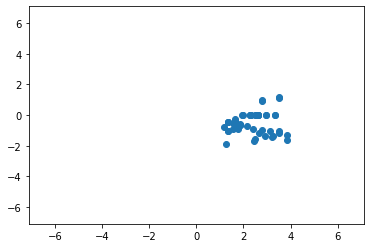

In [71]:
# The parameters are stored as a np.ndarray with units x parameters
# gf.iterative_search_params[:,0] -> x position of prf
# gf.iterative_search_params[:,1] -> y position of prf
# gf.iterative_search_params[:,2] -> size of prf
# gf.iterative_search_params[:,3] -> amplitude of prf
# gf.iterative_search_params[:,4] -> baseline of prf
# gf.iterative_search_params[:,5] -> rsq of prf


# Plot the x,y location of all the PRFs, which have a good fit...
good_fit_idx = gf.iterative_search_params[:, -1] > 0.1
good_fit_x = gf.iterative_search_params[good_fit_idx, 0]
good_fit_y = gf.iterative_search_params[good_fit_idx, 1]

plt.scatter(good_fit_x, good_fit_y)
plt.xlim(-max_eccentricity,max_eccentricity)
plt.ylim(-max_eccentricity,max_eccentricity)

In [72]:
# We can now create the predicted timeseries, and compare these with the data
prf_params = gf.iterative_search_params
pred_tc = gg.return_prediction(
    mu_x = prf_params[:,0], # x position
    mu_y = prf_params[:,1], # y position
    size = prf_params[:,2], # prf size
    beta = prf_params[:,3], # prf amplitude
    baseline = prf_params[:,4], # prf baseline (set to 0)
    hrf_1 = prf_params[:,5],
    hrf_2 = prf_params[:,6],
)

# Sometimes the fits are bad and will return NaN values. We do not want this so will remove them here:
pred_tc = filter_for_nans(pred_tc)

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:112: RuntimeWarning: divide by zero encountered in true_divide
  return (np.exp(-((x-mu[0])**2 + (y-mu[1])**2)/(2*sigma**2))).astype('float32')


In [ ]:
# Now to save everything in a nice convenient pickle file
print('saving iterative search params')
iter_file = './iter_fit.pkl'
iter_dict = {}
iter_dict['settings'] = prf_info # Save the settings into the pickle file
iter_dict['pars'] = gf.iterative_search_params # Save the parameters into the pickle file
iter_dict['preds'] = pred_tc # Save the predicted time series into the pickle file
iter_dict['date'] = datetime.now().strftime('%Y-%m-%d_%H-%M') # save the date into pickle
f = open(iter_file, "wb")
pickle.dump(iter_dict, f)
f.close()


In [ ]:
# To load this file all you need to do is:
pkl_file = open(iter_file,'rb')
loaded_iter_dict = pickle.load(pkl_file)
pkl_file.close()     

# Now you can access all the useful information together in one place


Have a look at the model fits:
* vary the voxel you are looking at (i_vx)
* also look at how the parameters (in the title), determine the location and size of the RF
* varying "time_pt", you can see where the stimulus is, at different times
* Note that the HRF means that responses of the model will be delayed...

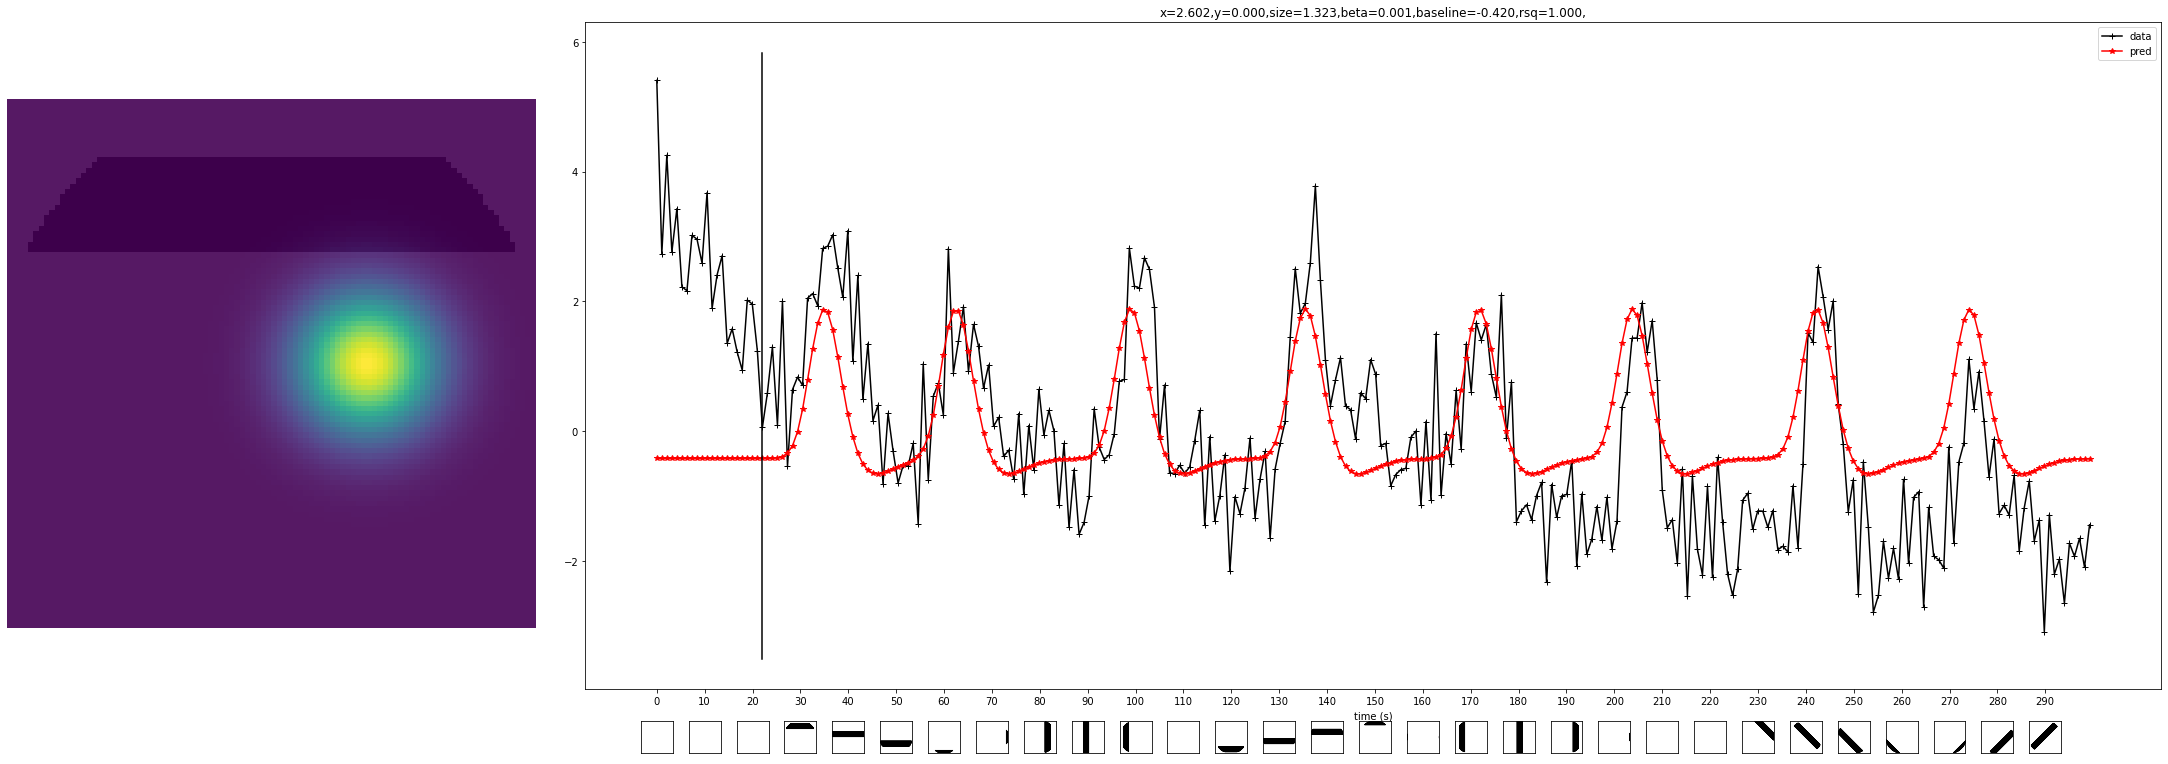

In [78]:
fig = plt.figure(constrained_layout=True, figsize=(30,10))
subfigs = fig.subfigures(1, 2, width_ratios=[10,30])
i_vx = 99

# ************* TIME COURSE PLOT *************
time_pts = np.arange(psc_avg_ts.shape[1]) * TR_s    
ax2 = subfigs[1].add_subplot()
ax2.plot(time_pts, psc_avg_ts[i_vx,:], '-+k', label= 'data')
ax2.plot(time_pts, pred_tc[i_vx,:], '-*r', label= 'pred')
ax2.set_xlabel('time (s)')
ax2.legend()

gauss_param_name = ['x', 'y', 'size', 'beta', 'baseline', 'rsq']
title_txt = ''
for i,p in enumerate(gauss_param_name):
    title_txt += f'{p}={prf_params[i_vx,i]:.3f},'
ax2.set_title(title_txt)

# ********* PRF PLOT **********
rf = gauss2D_iso_cart(
    x=prf_stim.x_coordinates,
    y=prf_stim.y_coordinates,
    mu=(prf_params[i_vx,0], prf_params[i_vx,1]),
    sigma=prf_params[i_vx,2])
ax1 = subfigs[0].add_subplot()
ax1.imshow(rf, vmin=0, vmax=1, extent=[-5,5,-5,5])
ax1.axis('off')

time_pt = 21
if time_pt != None:
    ax1.imshow(dm[:,:,time_pt], vmin=0, vmax=1,cmap='Greys', alpha=0.1, extent=[-5,5,-5,5])
    ax_lim = ax2.get_ylim()
    ax2.plot((time_pt*TR_s, time_pt*TR_s), (ax_lim), 'k')


ax2.set_xticks(np.arange(time_pts[0], time_pts[-1],10))
add_dm_to_ts(fig, ax2, dm, TR=1.5, dx_axs=2)    

# Guassian PRF widget
Here is a toy for you to get an intuition for the fitting procedure. Run the cell below, and you will see a plot of a real time series (black) and a red time series (prediction). You can vary the model parameters to try and make the red look as similar as the black as possible. Observe how the PRF shape changes. And how the 

In [74]:
import ipywidgets as widgets
from IPython.display import display, HTML


In [75]:
widg_model = Iso2DGaussianModel(
    stimulus=prf_stim,                                  # The stimulus we made earlier
    hrf=prf_info['hrf']['pars'],                        # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
    filter_predictions = prf_info['filter_predictions'],# Do you want to filter the predictions? (depends what you did to the data, try and match it... default is not to do anything)
    normalize_RFs= prf_info['normalize_RFs'],           # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
    )

time_pts = np.arange(psc_avg_ts.shape[1]) * TR_s    

def g_prf_widget(w_params):
    gauss_param_name = ['x', 'y', 'size', 'beta', 'baseline', 'hrf-deriv', 'hrf-disp']

    i_vx = int(w_params[-1])
    try: 
        print(f'For vx id = {i_vx}, best fit params are...')
        for i,p in enumerate(gauss_param_name):
            print(f'{p}={prf_params[i_vx,i]:.3f},')
    except Exception as e:
        pass


    data_to_plot = psc_avg_ts[i_vx,:]
    fig = plt.figure(constrained_layout=True, figsize=(30,10))
    subfigs = fig.subfigures(1, 2, width_ratios=[10,30])

    # ************* TIME COURSE PLOT *************
    
    ax2 = subfigs[1].add_subplot()
    ax2.plot(time_pts, data_to_plot, '-+k', label= 'data')
    w_params = np.array(w_params)
    # w_params = w_params[...,np.newaxis]
    # Create pred tc:
    w_pred = widg_model.return_prediction(
        mu_x = w_params[0], # x position
        mu_y = w_params[1], # y position
        size = w_params[2], # prf size
        beta = w_params[3], # prf amplitude
        baseline = w_params[4], # prf baseline (set to 0)
        hrf_1 = w_params[5],
        hrf_2 = w_params[6],        
    )
    w_pred = np.squeeze(w_pred)
    ax2.plot(time_pts, w_pred, '-*r', label= 'pred')
    ax2.set_xlabel('time (s)')
    ax2.legend()
    ax2.set_xticks(np.arange(time_pts[0], time_pts[-1],10))
    add_dm_to_ts(fig, ax2, dm, TR=1.5, dx_axs=2)

    gauss_param_name = ['x', 'y', 'size', 'beta', 'baseline', 'hrf-deriv', 'hrf-disp']
    title_txt = ''
    for i,p in enumerate(gauss_param_name):
        title_txt += f'{p}={w_params[i]:.3f},'
    rsq = get_rsq(data_to_plot, w_pred)
    title_txt += f'rsq={rsq:.3f}'
    ax2.set_title(title_txt)

    # ********* PRF PLOT **********
    rf = np.flipud(gauss2D_iso_cart(
        x=prf_stim.x_coordinates,
        y=prf_stim.y_coordinates,
        mu=(w_params[0], w_params[1]),
        sigma=w_params[2]))
    ax1 = subfigs[0].add_subplot()
    ax1.imshow(rf, vmin=0, vmax=1, extent=[-5,5,-5,5])
    # ax1.axis('off')
    
    # SHOW
    plt.show()

In [76]:
# ***************** WIDGETS & PARAMETERS VALUES *****************
# Starting params to show the "cartoon" model with dip in the centre

w_params = np.array((
    0,      #mu_x
    0,      #mu_y
    1,      #size
    .1,     #beta
    0,      #baseline
    1,      #hrf_1
    0,      #hrf_2
    0,    #i_vx
))

w_param_title = np.array([
    'mu_x',
    'mu_y',
    'size',
    'beta',
    'baseline',
    'hrf_1',
    'hrf_2',
    'i_vx',
])

w_param_min_max_step = np.array([
    [-6,6,.1],  #mu_x
    [-6,6,.1],  #mu_y
    [0,10,.1], #size
    [0,10,.01], #beta
    [-2,2,.1],  #baseline
    [0,10,.1],  #hrf_1
    [0,10,.1],   #hrf_2
    [0,100,1],  # i_vx    
])

widg_controls=[]
for i in range(len(w_params)):    
    sl=widgets.BoundedFloatText(description=w_param_title[i],
                           min=w_param_min_max_step[i,0], 
                           max=w_param_min_max_step[i,1], 
                           step=w_param_min_max_step[i,2], 
                           value=w_params[i],
                           orientation = "vertical",
                           continuous_update=False)    
    widg_controls.append(sl)
    
widg_Dict = {} 
for c in widg_controls:
    widg_Dict[c.description] = c  

left_widg = widgets.VBox(tuple([widg_controls[i] for i in range(4)]))
right_widg = widgets.VBox([widg_controls[i] for i in range(4,8)])
widg_uif = widgets.HBox([left_widg, right_widg])

def widg_update_N(**xvalor):
    xvalor=[]
    for i in range(len(widg_controls)):
        xvalor.append(widg_controls[i].value)
    
    g_prf_widget(xvalor)

widg_outf = widgets.interactive_output(widg_update_N,widg_Dict)
display(widg_uif, widg_outf)

Output()